# Lung segmentation from thoracic X-Ray images with UNET

*by Georgios K. Ouzounis*

## Contents

1. [The challenge](#the-challenge)
2. [Get the training data](#get-the-training-data)
3. [Get the code repo](#get-the-code-repo)
4. [Create the model](#create-the-model)
5. [Train the model](#train-the-model)
6. [Inference on test images](#inference-on-test-images)
7. [Acknowledgements](#acknowledgements)

## The challenge <a name="the-challenge"></a>

<img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/title2.png" width = "600"/>

Given an annotated image dataset of lungs from thoracic x-ray images, train a semantic segmentation model (UNET) and compute inference on new, previously unseen images.

**DISCLAIMER:**
In the following, "author" refers to Georgios Ouzounis.

- The work presented in this notebook is independent from past works of the author at varius companies and institutions. It is different with regards to the technology and code used and does not relate to any prior products, research work or IP developed by the author.
- This notebook (code) is developed explicitly for educational purposes, demonstrating how one can train the UNET model. It is not meant for any other usage and the author cannot be held accountable for its outcome and deliverables if used for a purpose different from the one stated.   

**IMPORTANT:** before start working on this notebook change your Runtime setting to GPU.

## Get the training data <a name="get-the-training-data"></a>

For this exercise will use a publicly available dataset of thoracic X-Ray images. It is posted in [kaggle.com](https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels) and is a kind contribution by [Nikhil Pandey](https://www.kaggle.com/nikhilpandey360). The archived collection is approximately 9.58 GB in size.

### Connect to Kaggle.com

We will import this dataset into our working  session directly from Kaggle. To read  more on how to import kaggle datasets directly into Google Colab please refer to this [documentation page](https://www.kaggle.com/general/74235).

In [1]:
# install the kaggle API
!pip install -q kaggle

In [2]:
# create a kaggle directory
!mkdir ~/.kaggle 

Right-click on the side bar and select Upload File in the root directory. Choose your kaggle.json token.

In [3]:
# move the token into the kaggle directory
!mv /content/kaggle.json ~/.kaggle/

In [4]:
# change the permisions of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 # test it out
 !kaggle datasets list

###  Get the dataset

In [6]:
# start the download
!kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

100% 9.56G/9.58G [03:46<00:00, 51.1MB/s]
100% 9.58G/9.58G [03:46<00:00, 45.5MB/s]


the above takes approximately 4 min to complete

### Setup the project data directories

Let us now create our dataset directory structure

In [7]:
%mkdir dataset
%mkdir dataset/images # for source images
%mkdir dataset/masks # for annotation masks
%mkdir dataset/test # for test images
%mkdir dataset/temp # temp storage

### Uncompress the archive

You will get a warning message about the storage usage which you may ignore as the dataset fits into the available space

In [ ]:
!unzip chest-xray-masks-and-labels.zip -d dataset/temp/

the above takes approximately 5 min to complete

In [9]:
# remove the original zip file
%rm chest-xray-masks-and-labels.zip

In [10]:
%ls dataset/temp/Lung\ Segmentation

ClinicalReadings/  masks/                       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png/           NLM-ChinaCXRSet-ReadMe.docx  test/


In [11]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
IMAGE_PATH = "/content/dataset/images/"

In [12]:
%mv dataset/temp/Lung\ Segmentation/masks/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'

In [13]:
%mv dataset/temp/Lung\ Segmentation/test/* dataset/test/
TEST_PATH = '/content/dataset/test/'

In [14]:
# clean-up
%rm -r dataset/temp/

| <img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/image1.png" width="300"/> | <img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/mask1.png" width="300"/> |
|:--:|:--:|
|example of an x-ray image | example of the corresponding annotation|

### Harmonize the dataset

Next, we will make several corrections to bring the contents of the ```images/``` and ```masks/``` directories in agreement with the UNET library requirements.

**Step 1:** some of the masks contain the ```_mask``` suffix in their file-name. Every image in the ```images/``` directory needs to have a mask in the ```masks/``` directory of exactly the same name. Thus we need to crop this suffix where ever it appears.

In [15]:
# importing os module
import os

# suffix cropping function
def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

suffix = "_mask.png"

# iterate over all mask images and edit the file-names
for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  res = rchop(src, suffix)
  dst = ""
  if src != res:
    dst = rchop(src, suffix) + ".png"
    os.rename(src, dst)

**Step 2:** Not all source images have corresponding mask images. We need to identify those that don't and remove them (place them in temp directory)

In [16]:
# check the number of files in the images/ and masks/ directories
import os.path

print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

number of files in images/ directory: 800
number of files in masks/ directory: 704


In [17]:
# function to confirm the existence of a file in a given directory
def searchFile(fileName, TARGET_PATH):
  for root, dirs, files in os.walk(TARGET_PATH):
    for Files in files:
      #print(Files)
      found = Files.find(fileName)
      if found != -1:
        break
  return found

In [18]:
%mkdir /content/dataset/orphan_images

In [19]:
# clean up the images/ directory by removing all images that do not have a mask
import shutil 

cnt = 0

for count, filename in enumerate(os.listdir("/content/dataset/images")):
  found = searchFile(filename, MASK_PATH)
  if found == -1:
    cnt = cnt + 1
    src = "/content/dataset/images/" + filename 
    dst = "/content/dataset/orphan_images/" + filename
    dest = shutil.move(src, dst) 
print("number of files not matched: " + str(cnt))

number of files not matched: 96


In [20]:
# confirm consistency
print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

number of files in images/ directory: 704
number of files in masks/ directory: 704


**Step 3:** convert mask images to binary. If there exist multiple classes one needs to set a unique pixel value for each class and re-format the mask images accordingly. In this case we have one class only (lungs) thus each image needs to be binary; 0 for background and 1 for lungs.

In [22]:
import cv2

for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  img = cv2.imread(src, cv2.IMREAD_GRAYSCALE)
  (T, res) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)
  cv2.imwrite(src, res)

the above takes approximately 60 sec to execute

## Get the code repo <a name="get-the-code-repo"></a>

The code repo is an edited version of Divan Gupta's [Image-Segmentation-Keras](https://github.com/divamgupta/image-segmentation-keras), to support Keras in TF2.5.

In [ ]:
!git clone https://github.com/georgiosouzounis/semantic-segmentation-tf2.git

In [26]:
%cd semantic-segmentation-tf2/

/content/semantic-segmentation-tf2


## Create the model <a name="create-the-model"></a>

Before we create the model let us first find a reasonable set of dimensions to resize our input images to. 


In [27]:
# check the image attributes
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/dataset/test/CHNCXR_0194_0.png")
img.shape

(2992, 2991, 3)

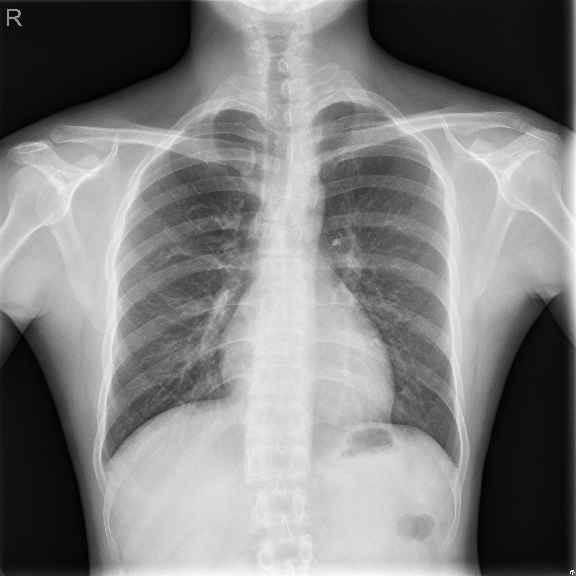

In [28]:
img = cv2.resize(img, (576, 576))
cv2_imshow(img)

In [29]:
# import the vgg_unet model
from tf2_sem_seg.models.unet import vgg_unet

In [30]:
# instantiate our model:
# + n_classes = 1 (background) + 1 (lungs)
# + input_height: resized number of rows for input image; must be divisable by 32
# + input_width:  resized number of cols for input image; must be divisable by 32
model = vgg_unet(n_classes=2, input_height=576, input_width=576)

58892288/58889256 [==============================] - 1s 0us/step


Let us now review the model we just instantiated and compare it against the u-net and vgg16 architectures.


| <img src="https://github.com/georgiosouzounis/lung-seg-xray-unet/raw/main/images/unet.png" width="500"/> | <img src="https://github.com/georgiosouzounis/lung-seg-xray-unet/raw/main/images/vgg16.png" width="500"/> |
|:---:|:---:|
|the u-net architecture | the vgg16 architecture |

In [ ]:
# review the model
print(model.summary())

In [ ]:
# review the model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train the model <a name="train-the-model"></a>

In [38]:
# create a temporary directory for model checkpoints
%mkdir /content/tmp/

In [39]:
# train_images: directory containing the source images for training
# train_annotations: directory containing the masks for training
# checkpoints_path: directory for storing weights and logs
# epochs: the number of training epochs set to 5 for the demo. 
#   Increase this to a higher number for better results.
model.train(
    train_images =  "../dataset/images/",
    train_annotations = "../dataset/masks/",
    checkpoints_path = "../tmp/vgg_unet_1" , epochs=5 
)

  0%|          | 0/704 [00:00<?, ?it/s]

Verifying training dataset


100%|██████████| 704/704 [02:33<00:00,  4.58it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 268s 447ms/step - loss: 0.1200 - accuracy: 0.9562

Epoch 00001: saving model to ../tmp/vgg_unet_1.00001
Epoch 2/5
512/512 [==============================] - 223s 436ms/step - loss: 0.0623 - accuracy: 0.9776

Epoch 00002: saving model to ../tmp/vgg_unet_1.00002
Epoch 3/5
512/512 [==============================] - 220s 430ms/step - loss: 0.0583 - accuracy: 0.9790

Epoch 00003: saving model to ../tmp/vgg_unet_1.00003
Epoch 4/5
512/512 [==============================] - 224s 437ms/step - loss: 0.0941 - accuracy: 0.9653

Epoch 00004: saving model to ../tmp/vgg_unet_1.00004
Epoch 5/5
512/512 [==============================] - 223s 436ms/step - loss: 0.0564 - accuracy: 0.9795

Epoch 00005: saving model to ../tmp/vgg_unet_1.00005


In [ ]:
# make a backup in your Google Drive
%cp /content/tmp/* /content/drive/MyDrive/deep-learning/lung-seg-xray/

## Inference on test images <a name="inference-on-test-images"></a>

In [40]:
out = model.predict_segmentation(
    inp="/content/dataset/test/CHNCXR_0025_0.png",
    out_fname="/content/tmp/out.png"
)

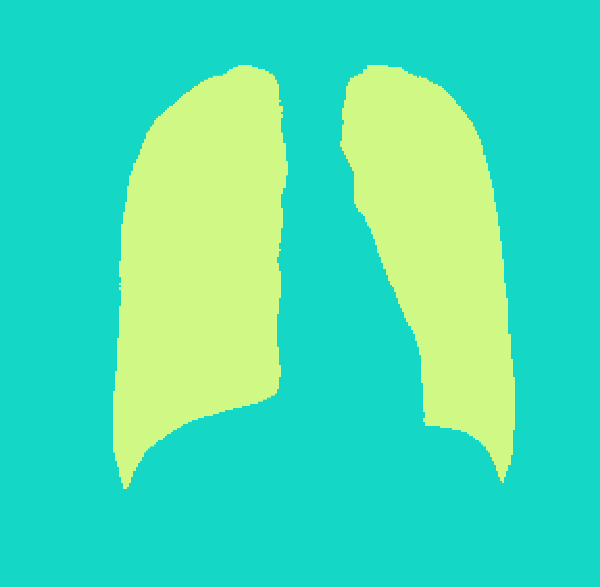

In [41]:
img = cv2.imread("/content/tmp/out.png")
img = cv2.resize(img, (int(img.shape[1]/5), int(img.shape[0]/5)))
cv2_imshow(img)


In [42]:
# alpha-blend the inference with the source
o = model.predict_segmentation(
    inp="/content/dataset/test/CHNCXR_0025_0.png",
    out_fname="/content/tmp/out_blend.png" , overlay_img=True, show_legends=True,
    class_names = ["background","lungs"]
)

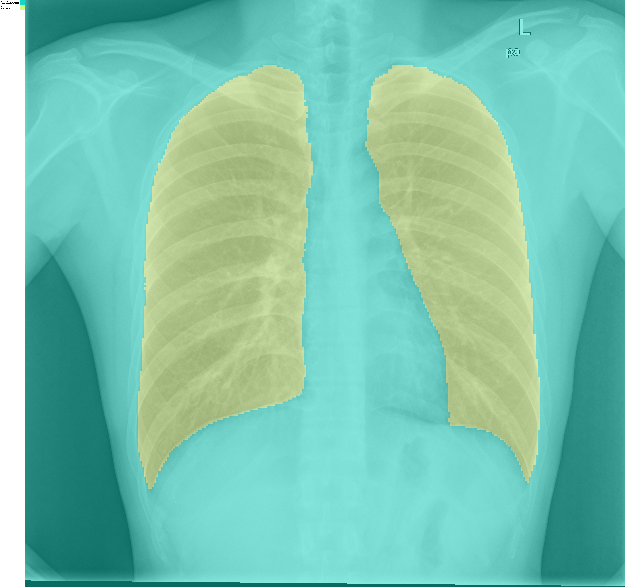

In [43]:
img = cv2.imread("/content/tmp/out_blend.png")
img = cv2.resize(img, (int(img.shape[1]/5), int(img.shape[0]/5)))
from google.colab.patches import cv2_imshow
cv2_imshow(img)

## Acknowledgements <a name="acknowledgements"></a>

The author would like to thank and acknowledge the following:

- [Divan Gupta](https://github.com/divamgupta) and all other contributors to the ```Image Segmentation Keras : Implementation of Segnet, FCN, UNet, PSPNet and other models in Keras``` [repo](https://github.com/divamgupta/image-segmentation-keras) for their amazing work in putting all the functionality together to make semantic segmentation accessible through Keras.
- [Nikhil Pandey](https://www.kaggle.com/nikhilpandey360) for posting an excellent quality X-Ray dataset of thoracic scans in Kaggle.  